In [39]:
import numpy
numpy.version.version

'1.26.4'

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

In [41]:
X_train = pd.read_csv('../../data/train_in.csv', header=None)
y_train = pd.read_csv('../../data/train_out.csv', header=None).values.flatten()

In [42]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

In [43]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_train)

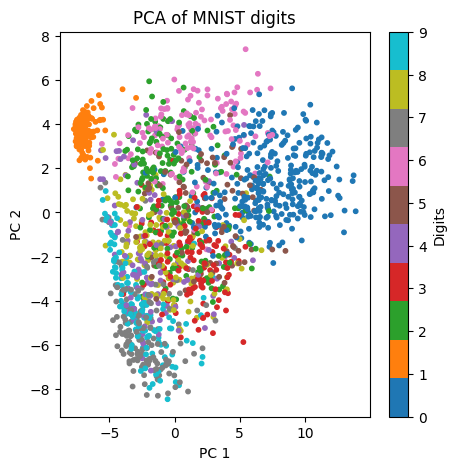

In [44]:
plt.figure(figsize=(5, 5))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='tab10', alpha=1, s=10)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA of MNIST digits')
plt.colorbar(scatter, ticks=range(10), label='Digits')
plt.show()

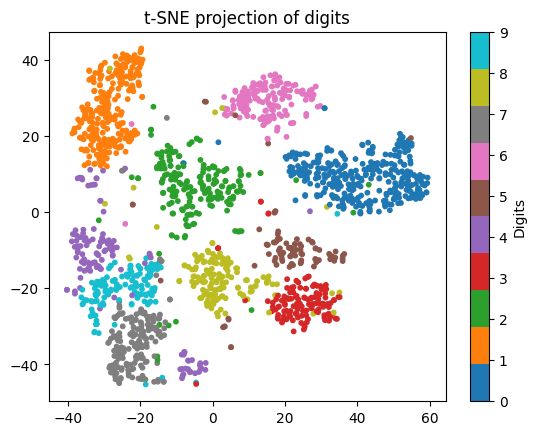

In [45]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap='tab10', s=10)
plt.colorbar(ticks=range(10), label='Digits')
plt.title("t-SNE projection of digits")
plt.show()

In [46]:
umap_model = UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1, metric='cosine')
X_umap = umap_model.fit_transform(X_train)

/Users/rwikkamilya/MSc/Intro_DL/intro_dl_ass_0/.venv3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


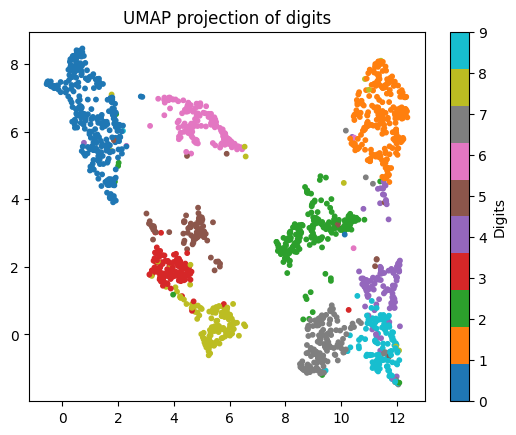

In [47]:
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_train, cmap='tab10', s=10)
plt.colorbar(ticks=range(10), label='Digits')
plt.title("UMAP projection of digits")
plt.show()

In [53]:
import numpy as np
from matplotlib.colors import ListedColormap, Normalize

def get_digit_cmap():
    colors = [
        "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
        "#8c564b", "#e377c2", "#7f7f7f", "#17becf", "#bcbd22"
    ]
    return ListedColormap(colors), Normalize(vmin=0, vmax=9)


def scatter_panel(ax, emb, y, title):
    cmap, norm = get_digit_cmap()
    sc = ax.scatter(emb[:, 0], emb[:, 1], s=10, c=y, cmap=cmap, norm=norm, alpha=0.9)
    ax.set_title(title, pad=6)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])
    ax.set_yticks([])
    return sc


def add_shared_colorbar(fig, mappable, label="Digits"):
    cbar = fig.colorbar(mappable, ax=fig.axes, fraction=0.02, pad=0.02)
    cbar.set_label(label)


def figure_pca(X, y, savepath="fig_pca.png", random_state=42):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
    pca = PCA(n_components=2, random_state=random_state)
    pca_2d = pca.fit_transform(X)
    sc = scatter_panel(ax, pca_2d, y, "PCA (PC1 vs PC2)")
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")
    add_shared_colorbar(fig, sc)
    plt.subplots_adjust(top=0.90)
    fig.suptitle("PCA of MNIST digits", y=1.10, fontsize=14, fontweight="bold")
    fig.savefig(savepath, dpi=200)
    plt.close(fig)


def figure_tsne(X, y, perplexities=(5, 30, 300), savepath="fig_tsne.png", random_state=42):
    n_cols = len(perplexities)
    fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, 5), constrained_layout=True)
    if n_cols == 1:
        axes = [axes]

    last_sc = None
    for ax, p in zip(axes, perplexities):
        tsne = TSNE(
            n_components=2,
            perplexity=p,
            learning_rate="auto",
            init="pca",
            random_state=random_state,
            metric="euclidean",
            verbose=0
        )
        emb = tsne.fit_transform(X)
        last_sc = scatter_panel(ax, emb, y, f"t-SNE (perplexity={p})")

    add_shared_colorbar(fig, last_sc)
    plt.subplots_adjust(top=0.90)
    fig.suptitle("t-SNE projection of digits — perplexity sensitivity", y=1.10, fontsize=14, fontweight="bold")
    fig.savefig(savepath, dpi=200)
    plt.close(fig)


def figure_umap(X, y, configs=None, savepath="fig_umap.png", random_state=42):
    if configs is None:
        configs = [
            {"title": "UMAP default", "n_neighbors": 15, "min_dist": 0.1, "metric": "euclidean"},
            {"title": "n_neighbors=2", "n_neighbors": 2, "min_dist": 0.1, "metric": "euclidean"},
            {"title": "n_neighbors=100", "n_neighbors": 100, "min_dist": 0.1, "metric": "euclidean"},
            {"title": "min_dist=0.5", "n_neighbors": 15, "min_dist": 0.5, "metric": "euclidean"},
            {"title": "min_dist=1.0", "n_neighbors": 15, "min_dist": 1.0, "metric": "euclidean"},
            {"title": "metric='cosine'", "n_neighbors": 15, "min_dist": 0.1, "metric": "cosine"},
        ]

    n = len(configs)
    n_cols = 3
    n_rows = int(np.ceil(n / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows), constrained_layout=True)
    axes = np.array(axes).reshape(-1)
    last_sc = None

    for ax, cfg in zip(axes[:n], configs):
        umap_model = UMAP(
            n_components=2,
            random_state=random_state,
            n_neighbors=cfg.get("n_neighbors", 15),
            min_dist=cfg.get("min_dist", 0.1),
            metric=cfg.get("metric", "euclidean")
        )
        emb = umap_model.fit_transform(X)
        last_sc = scatter_panel(ax, emb, y, cfg.get("title", "UMAP"))

    for ax in axes[n:]:
        ax.axis("off")

    add_shared_colorbar(fig, last_sc)
    plt.subplots_adjust(top=0.90)
    fig.suptitle("UMAP projection of digits — parameter sensitivity", y=1.10, fontsize=14, fontweight="bold")
    fig.savefig(savepath, dpi=200)
    plt.close(fig)


In [54]:
figure_pca(X_train, y_train, savepath="pca_grid.png")
figure_tsne(X_train, y_train, perplexities=(5, 30, 300), savepath="tsne_grid.png")
figure_umap(X_train, y_train, savepath="umap_grid.png")

/var/folders/k2/6gngzy8172ng5cmc08j5rqz80000gn/T/ipykernel_67283/605301595.py:36: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(top=0.90)
/var/folders/k2/6gngzy8172ng5cmc08j5rqz80000gn/T/ipykernel_67283/605301595.py:63: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(top=0.90)
/Users/rwikkamilya/MSc/Intro_DL/intro_dl_ass_0/.venv3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/rwikkamilya/MSc/Intro_DL/intro_dl_ass_0/.venv3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/rwikkamilya/MSc/Intro_DL/intro_dl_ass_0/.venv3.12/lib/p